In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [7]:
path_to_train = os.path.join('data','train.csv')
path_to_test = os.path.join('data','test.csv')

train_df = pd.read_csv(path_to_train)
test_df = pd.read_csv(path_to_test)

def clean_and_feature_eng(df):
    data = df.dropna()
    data = pd.get_dummies(data, columns=['Sex'], drop_first=True, dtype=float)
    data.fillna(data.mean(), inplace=True)
    return data

train_df = clean_and_feature_eng(train_df)
test_df = clean_and_feature_eng(test_df)

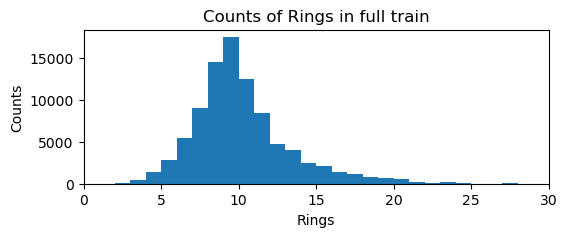

In [14]:
def plot_hist_variables(df, variable='Rings', dataset_name='full train'):
    bins = [i for i in range(31)]
    x = df[variable]

    fig, ax = plt.subplots(figsize=(6,2))
    ax.hist(x, bins=bins)
    ax.set_xlim((0, 30))
    ax.set_xlabel(variable)
    ax.set_ylabel('Counts')
    ax.set_title(f'Counts of {variable} in {dataset_name}')
    plt.show()

plot_hist_variables(train_df)

In [18]:
target = 'Rings'
X = train_df.drop([target, 'id'], axis=1)
y = train_df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_test = test_df.drop(['id'], axis=1)
X_test_scaled = scaler.transform(X_test)

In [23]:
%%time

model = GradientBoostingRegressor(n_estimators=100)
model.fit(X_train_scaled, y_train)

CPU times: user 4.61 s, sys: 15.5 ms, total: 4.63 s
Wall time: 4.66 s


GradientBoostingRegressor()

In [32]:
predictions_val = model.predict(X_val_scaled)

def RMSLEScore(y_truth, y_pred):
    y_pred[y_pred<=0] = 1e-6
    return np.sqrt(np.mean(np.square(np.log(y_truth+1) - np.log(y_pred+1))))
rmsleScore = RMSLEScore(y_val, predictions_val)
print(f'Root mean squared logarithmic error: {rmsleScore:.4f}')

Root mean squared logarithmic error: 0.1534


In [36]:
predictions_test = model.predict(X_test_scaled)
sub = pd.DataFrame({'id': test_df.id.values})
sub['Rings'] = predictions_test
sub.to_csv('submission.csv', index=False)

training dataset set, mean: 9.697
training dataset set, std. dev.: 3.176
---
validation dataset predictions set, mean: 9.692
validation dataset predictions set, std. dev.: 2.499
---
test dataset predictions set, mean: 9.703
test dataset predictions set, std. dev.: 2.481
---


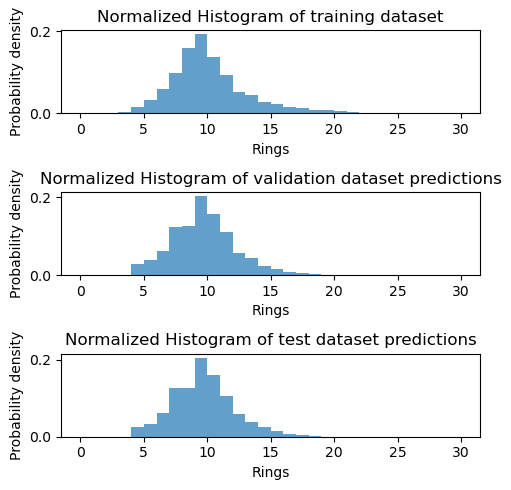

In [41]:
def print_stats(targets, dataset_name):
    mean_value = targets.mean()
    std_dev = targets.std()
    print(f'{dataset_name} set, mean: {mean_value:.3f}')
    print(f'{dataset_name} set, std. dev.: {std_dev:.3f}')
    
dfs = [('training dataset', train_df['Rings']),
       ('validation dataset predictions', predictions_val),
       ('test dataset predictions', predictions_test)]

for name, df in dfs:
    print_stats(df, name)
    print('---')
    
# visualise predictions
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5,5))

for ax, (name, data) in zip(axes.flatten(), dfs):
    counts, bins = np.histogram(data, bins=[i for i in range(0,31)], density=True)
    ax.hist(bins[:-1], bins, weights=counts, alpha=0.7, label=f'Normalized {name}')
    ax.set_title(f'Normalized Histogram of {name}')
    ax.set_xlabel('Rings')
    ax.set_ylabel('Probability density')

plt.tight_layout()
plt.show()


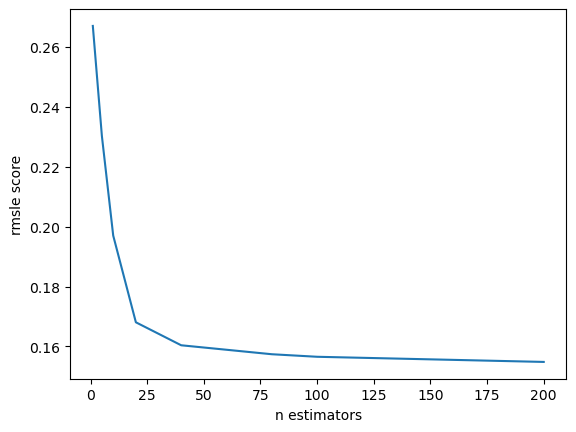

CPU times: user 21.1 s, sys: 108 ms, total: 21.2 s
Wall time: 21.5 s


In [44]:
%%time
# Train GradientBoostingRegressor trees with different numbers of estimators and plot RMSLE vs n_estimators
def train_multiple(regressor = None, estimators = None):
    if regressor == None:
        regressor = GradientBoostingRegressor
    if estimators == None:
        estimators = [1, 5, 10, 20, 40, 80, 100, 200]
        
    res = [] # list of tuples (n_estimators, rmsle_score, train_time, inference_time)

    for n in estimators:
        t0 = time.time()
        model = regressor(n_estimators=n)
        model.fit(X_train_scaled, y_train)
        t1 = time.time()
        train_time = t1-t0

        t0 = time.time()
        predictions_val = model.predict(X_val_scaled)
        predictions_val = predictions_val.round()
        t1 = time.time()
        inference_time = t1-t0

        rmsle_score = RMSLEScore(y_val, predictions_val)

        res.append((n, rmsle_score, train_time, inference_time))
        
    return res 

res = train_multiple()
xx = [res[i][0] for i in range(len(res))]
score = [res[i][1] for i in range(len(res))]

plt.plot(xx, score)
plt.xlabel('n estimators')
plt.ylabel('rmsle score')
plt.show()